In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
print("scikit-learn installed successfully!")

scikit-learn installed successfully!


In [2]:
df = pd.read_pickle('../data/clean_data.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1393 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   battery_power  1393 non-null   int16   
 1   blue           1393 non-null   category
 2   clock_speed    1393 non-null   float16 
 3   dual_sim       1393 non-null   category
 4   fc             1393 non-null   int8    
 5   four_g         1393 non-null   category
 6   int_memory     1393 non-null   int8    
 7   m_dep          1393 non-null   float16 
 8   mobile_wt      1393 non-null   int16   
 9   n_cores        1393 non-null   int8    
 10  pc             1393 non-null   int8    
 11  px_height      1393 non-null   int16   
 12  px_width       1393 non-null   int16   
 13  ram            1393 non-null   int16   
 14  sc_h           1393 non-null   int8    
 15  sc_w           1393 non-null   int8    
 16  talk_time      1393 non-null   int8    
 17  three_g        1393 non-null   categor

In [3]:
df = df.rename(columns={'price_range': 'target'})
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [4]:
cat_features = df.drop('target', axis=1) \
                    .select_dtypes(include=['category']).columns.to_list()
print(cat_features)

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']


In [5]:
num_features = df.select_dtypes(include=['number']).columns.to_list()
print(num_features)

['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']


In [6]:
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
s_scaler = StandardScaler()
l_encoder = TargetEncoder()
classifier = RandomForestClassifier()

In [7]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
        ('cat', l_encoder, cat_features), # –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    ],
    remainder='drop' )

In [8]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model', RandomForestClassifier())])

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

predictions = pipeline.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

print(metrics)

{'precision': 0.8207110377338568, 'recall': 0.8223495702005731, 'f1': 0.8205986457225606}


In [10]:
import mlflow

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [11]:
EXPERIMENT_NAME = "phone_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "phone_model_rf"

In [12]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [13]:
req_file = '../requirements.txt'
params_dict = pipeline.get_params()

In [14]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
  
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)

    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/22 10:14:23 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/10/22 10:14:23 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies us

In [15]:
classifier2 = RandomForestClassifier()

In [16]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier2)])

print(pipeline.fit(X_train, y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model', RandomForestClassifier())])


In [17]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

print(metrics)

{'precision': 0.8443742066568649, 'recall': 0.8452722063037249, 'f1': 0.8444764396352786}


In [18]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, QuantileTransformer

X_train_fe_sklearn = X_train.copy()

pf = PolynomialFeatures(degree=2)

X_train_fe_sklearn

battery_power blue  clock_speed dual_sim  fc four_g  int_memory  \
1274           1602    0     2.699219        0   4      1          46   
991             860    1     1.599609        1  13      0          48   
1720           1248    0     2.400391        0   6      1           9   
169            1569    0     2.800781        1  17      0          44   
151             742    0     2.199219        1   4      0          56   
...             ...  ...          ...      ...  ..    ...         ...   
677            1260    0     0.600098        0   5      1          13   
443            1448    0     1.400391        1  13      0          26   
716             863    0     1.599609        1   5      1           6   
767            1853    0     0.500000        1   1      0          27   
1722           1831    1     2.300781        0   3      1          44   

         m_dep  mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  \
1274  0.600098        118        1   5        273      1062  1862    16     9   
991   0.500000        187        7  18        335      1463  1870    17     2   
1720  0.399902         89        3   8         71      1686  2454     9     8   
169   0.300049        110        4  20         45      1942  1260     9     2   
151   0.199951        190        7  14        577      1359  3557    16    11   
...        ...        ...      ...  ..        ...       ...   ...   ...   ...   
677   1.000000        106        6   6        165       736  2710    13     1   
443   1.000000        156        3  16       1792      1850  1175    12     9   
716   0.700195        133        4  13        717      1799   520    10     2   
767   0.300049        197        6  13        985      1005  1973    10     2   
1722  0.199951        148        7  14        437      1113  2460    10     5   

      talk_time three_g touch_screen wifi  
1274          2       1            0    1  
991          18       1            0    0  
1720         13       1            1    0  
169          17       1            0    0  
151          12       0            1    1  
...         ...     ...          ...  ...  
677           8       1            1    0  
443           6       0            1    0  
716          18       1            0    1  
767           8       1            0    1  
1722         18       1            0    0  

[1044 rows x 20 columns]

In [19]:
pf.fit_transform(X_train_fe_sklearn[['battery_power','clock_speed']])

array([[1.0000000e+00, 1.6020000e+03, 2.6992188e+00, 2.5664040e+06,
        4.3241484e+03, 7.2857819e+00],
       [1.0000000e+00, 8.6000000e+02, 1.5996094e+00, 7.3960000e+05,
        1.3756641e+03, 2.5587502e+00],
       [1.0000000e+00, 1.2480000e+03, 2.4003906e+00, 1.5575040e+06,
        2.9956875e+03, 5.7618752e+00],
       ...,
       [1.0000000e+00, 8.6300000e+02, 1.5996094e+00, 7.4476900e+05,
        1.3804629e+03, 2.5587502e+00],
       [1.0000000e+00, 1.8530000e+03, 5.0000000e-01, 3.4336090e+06,
        9.2650000e+02, 2.5000000e-01],
       [1.0000000e+00, 1.8310000e+03, 2.3007812e+00, 3.3525610e+06,
        4.2127305e+03, 5.2935944e+00]], dtype=float32)

In [20]:
sp = SplineTransformer(n_knots=3, degree=3)
sp.fit_transform(X_train_fe_sklearn[['battery_power']])

array([[0.00000000e+00, 2.46807807e-02, 4.97104628e-01, 4.60806518e-01,
        1.74080730e-02],
       [2.34852789e-02, 4.91792463e-01, 4.66333319e-01, 1.83889394e-02,
        0.00000000e+00],
       [1.34136544e-09, 1.67670675e-01, 6.66662655e-01, 1.65666669e-01,
        0.00000000e+00],
       ...,
       [2.29467841e-02, 4.89326304e-01, 4.68873106e-01, 1.88538066e-02,
        0.00000000e+00],
       [0.00000000e+00, 1.21165043e-03, 2.78655972e-01, 6.32773879e-01,
        8.73584981e-02],
       [0.00000000e+00, 1.85106960e-03, 2.97559585e-01, 6.22440513e-01,
        7.81488322e-02]])

In [21]:
qt = QuantileTransformer()
qt.fit_transform(X_train_fe_sklearn[['battery_power']])

array([[0.72272272],
       [0.25675676],
       [0.48825821],
       ...,
       [0.25982742],
       [0.88988989],
       [0.87337337]])

In [22]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [23]:
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [24]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
        ('cat', l_encoder, cat_features), # –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
        ('quantile', qt, num_features),
        ('poly', pf_pipeline, ['battery_power', 'clock_speed']),
        ('spline', sp, ['battery_power'])
    ],
    remainder='drop',
    )

In [25]:
X_train_fe_sklearn[['battery_power','clock_speed']] = X_train_fe_sklearn[['battery_power','clock_speed']].astype('float64')
X_train_fe_sklearn[['battery_power','clock_speed']] = X_train_fe_sklearn[['battery_power','clock_speed']].astype('float64')

In [26]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_fe_sklearn, y_train)
X_train_fe_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

In [27]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_fe_sklearn)

num__battery_power  num__clock_speed   num__fc  num__int_memory  \
0               0.777362          1.488088 -0.388073         0.755495   
1              -0.877470          0.142815  1.773360         0.866851   
...                  ...               ...       ...              ...   
1042            1.337150         -1.202458 -1.108551        -0.302390   
1043            1.288085          1.000636 -0.628233         0.644139   

      num__m_dep  num__mobile_wt  num__n_cores   num__pc  num__px_height  \
0       0.320357       -0.636411     -1.513350 -1.229331       -0.818486   
1      -0.022591        1.311435      1.083096  1.250895       -0.679668   
...          ...             ...           ...       ...             ...   
1042   -0.707650        1.593731      0.650355  0.296962        0.775675   
1043   -1.050598        0.210479      1.083096  0.487749       -0.451292   

      num__px_width  num__ram  num__sc_h  num__sc_w  num__talk_time  \
0         -0.428872 -0.270530   0.836614   0.633973       -1.660931   
1          0.492608 -0.263196   1.078025  -1.070617        1.278695   
...             ...       ...        ...        ...             ...   
1042      -0.559856 -0.168767  -0.611852  -1.070617       -0.558571   
1043      -0.311677  0.277708  -0.611852  -0.340078        1.278695   

      cat__blue_0  cat__blue_1  cat__blue_2  cat__blue_3  cat__dual_sim_0  \
0        0.265001     0.265017     0.233762     0.236208         0.268625   
1        0.233906     0.233922     0.262487     0.269681         0.217013   
...           ...          ...          ...          ...              ...   
1042     0.254685     0.249997     0.247633     0.247682         0.201580   
1043     0.228187     0.247576     0.240300     0.283934         0.278708   

      cat__dual_sim_1  cat__dual_sim_2  cat__dual_sim_3  cat__four_g_0  \
0            0.222019         0.261643         0.247702       0.236024   
1            0.259322         0.231953         0.291702       0.243773   
...               ...              ...              ...            ...   
1042         0.263643         0.241300         0.293459       0.241136   
1043         0.235054         0.246538         0.239687       0.242130   

      cat__four_g_1  cat__four_g_2  cat__four_g_3  cat__three_g_0  \
0          0.248175       0.248169       0.267633        0.233508   
1          0.241310       0.261153       0.253761        0.229938   
...             ...            ...            ...             ...   
1042       0.245870       0.257650       0.255343        0.234461   
1043       0.251809       0.230057       0.276003        0.234461   

      cat__three_g_1  cat__three_g_2  cat__three_g_3  cat__touch_screen_0  \
0           0.244772        0.252806        0.268914             0.230430   
1           0.247245        0.250386        0.272430             0.219854   
...              ...             ...             ...                  ...   
1042        0.244027        0.247204        0.274308             0.239442   
1043        0.244027        0.247204        0.274308             0.239442   

      cat__touch_screen_1  cat__touch_screen_2  cat__touch_screen_3  \
0                0.249403             0.263613             0.256551   
1                0.248790             0.277694             0.253652   
...                   ...                  ...                  ...   
1042             0.246484             0.258181             0.255891   
1043             0.246484             0.258181             0.255891   

      cat__wifi_0  cat__wifi_1  cat__wifi_2  cat__wifi_3  \
0        0.233664     0.275632     0.224346     0.266351   
1        0.273296     0.211110     0.261351     0.254224   
...           ...          ...          ...          ...   
1042     0.233051     0.280466     0.228540     0.257935   
1043     0.251244     0.213279     0.261375     0.274090   

      quantile__battery_power  quantile__clock_speed  quantile__fc  \
0                    0.722723          

In [28]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', classifier)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

In [29]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

print(metrics)

{'precision': 0.8803517797995376, 'recall': 0.8739255014326648, 'f1': 0.8754037553058572}


In [30]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name="fe_sklearn", experiment_id=experiment_id) as run:
   
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)

    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/22 10:14:24 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:25 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:25 INFO mlflow.tracking._tracking_service.client: üèÉ View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/ce1e580f21134af0b6e5868bce88be43.
2025/10/22 10:14:25 INFO mlflow.tracking._t

In [31]:
from sklearn.feature_selection import RFE
X_train_fe_sklearn

num__battery_power  num__clock_speed   num__fc  num__int_memory  \
0               0.777362          1.488088 -0.388073         0.755495   
1              -0.877470          0.142815  1.773360         0.866851   
2              -0.012140          1.122499  0.092245        -1.304597   
3               0.703764          1.612341  2.733996         0.644139   
4              -1.140637          0.876383 -0.388073         1.312276   
...                  ...               ...       ...              ...   
1039            0.014623         -1.079997 -0.147914        -1.081884   
1040            0.433906         -0.100911  1.773360        -0.358068   
1041           -0.870779          0.142815 -0.147914        -1.471631   
1042            1.337150         -1.202458 -1.108551        -0.302390   
1043            1.288085          1.000636 -0.628233         0.644139   

      num__m_dep  num__mobile_wt  num__n_cores   num__pc  num__px_height  \
0       0.320357       -0.636411     -1.513350 -1.229331       -0.818486   
1      -0.022591        1.311435      1.083096  1.250895       -0.679668   
2      -0.365539       -1.455071     -0.647868 -0.656971       -1.270762   
3      -0.707650       -0.862248     -0.215127  1.632469       -1.328975   
4      -1.050598        1.396124      1.083096  0.487749       -0.137833   
...          ...             ...           ...       ...             ...   
1039    1.690475       -0.975167      0.650355 -1.038545       -1.060297   
1040    1.690475        0.436316     -0.647868  0.869322        2.582539   
1041    0.663305       -0.212966     -0.215127  0.296962        0.175626   
1042   -0.707650        1.593731      0.650355  0.296962        0.775675   
1043   -1.050598        0.210479      1.083096  0.487749       -0.451292   

      num__px_width  ...  poly__battery_power  poly__clock_speed  \
0         -0.428872  ...             0.777362           1.488088   
1          0.492608  ...            -0.877470           0.142815   
2          1.005052  ...            -0.012140           1.122499   
3          1.593328  ...             0.703764           1.612341   
4          0.253620  ...            -1.140637           0.876383   
...             ...  ...                  ...                ...   
1039      -1.178006  ...             0.014623          -1.079997   
1040       1.381916  ...             0.433906          -0.100911   
1041       1.264720  ...            -0.870779           0.142815   
1042      -0.559856  ...             1.337150          -1.202458   
1043      -0.311677  ...             1.288085           1.000636   

      poly__battery_power^2  poly__battery_power clock_speed  \
0                  0.701249                         1.944147   
1                 -0.911679                        -0.382570   
2                 -0.189533                         0.895828   
3                  0.608857                         1.999604   
4                 -1.078584                        -0.180431   
...                     ...                              ...   
1039              -0.162960                        -0.871464   
1040               0.286540                         0.132018   
1041              -0.907115                        -0.378783   
1042               1.466925                        -0.737016   
1043               1.395366                         1.856224   

      poly__clock_speed^2  spline__battery_power_sp_0  \
0                1.667971                0.000000e+00   
1               -0.116371                2.348528e-02   
2                1.092732                1.341365e-09   
3                1.878827                0.000000e+00   
4                0.743449                5.194951e-02   
...                   ...                         ...   
1039            -0.946303                0.000000e+00   
1040            -0.341972                0.000000e+00   
1041            -0.116371                2.294678e-02   
1042            -0.987870                0.000000e+00   
104

In [32]:
rfe_skl_selector = RFE(estimator=classifier, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_fe_sklearn,y_train)

In [33]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

num__px_height  num__px_width  num__ram  quantile__mobile_wt  \
0          -0.818486      -0.428872 -0.270530             0.321321   
1          -0.679668       0.492608 -0.263196             0.885385   
2          -1.270762       1.005052  0.272207             0.081582   
3          -1.328975       1.593328 -0.822435             0.251251   
4          -0.137833       0.253620  1.283421             0.906907   
...              ...            ...       ...                  ...   
1039       -1.060297      -1.178006  0.506904             0.222222   
1040        2.582539       1.381916 -0.900361             0.625125   
1041        0.175626       1.264720 -1.500856             0.438438   
1042        0.775675      -0.559856 -0.168767             0.960961   
1043       -0.451292      -0.311677  0.277708             0.560561   

      quantile__px_height  quantile__px_width  quantile__ram  \
0                0.249249            0.373373       0.411109   
1                0.311601            0.650651       0.416107   
2                0.049049            0.786286       0.579099   
3                0.030681            0.960460       0.267350   
4                0.521021            0.578930       0.873178   
...                   ...                 ...            ...   
1039             0.141029            0.165165       0.651498   
1040             0.989077            0.894394       0.235033   
1041             0.625626            0.866627       0.067100   
1042             0.778779            0.335335       0.445042   
1043             0.398398            0.400767       0.584738   

      poly__battery_power  poly__battery_power^2  \
0                0.777362               0.701249   
1               -0.877470              -0.911679   
2               -0.012140              -0.189533   
3                0.703764               0.608857   
4               -1.140637              -1.078584   
...                   ...                    ...   
1039             0.014623              -0.162960   
1040             0.433906               0.286540   
1041            -0.870779              -0.907115   
1042             1.337150               1.466925   
1043             1.288085               1.395366   

      poly__battery_power clock_speed  spline__battery_power_sp_1  \
0                            1.944147                    0.024681   
1                           -0.382570                    0.491792   
2                            0.895828                    0.167671   
3                            1.999604                    0.031379   
4                           -0.180431                    0.579687   
...                               ...                         ...   
1039                        -0.871464                    0.159751   
1040                         0.132018                    0.066124   
1041                        -0.378783                    0.489326   
1042                        -0.737016                    0.001212   
1043                         1.856224                    0.001851   

      spline__battery_power_sp_3  
0                       0.460807  
1                       0.018389  
2                       0.165667  
3                       0.432308  
4                       0.005563  
...                          ...  
1039                    0.173778  
1040                    0.325104  
1041                    0.018854  
1042                    0.632774  
1043                    0.622441  

[1044 rows x 12 columns]

In [34]:

rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__px_height',
 'num__px_width',
 'num__ram',
 'quantile__mobile_wt',
 'quantile__px_height',
 'quantile__px_width',
 'quantile__ram',
 'poly__battery_power',
 'poly__battery_power^2',
 'poly__battery_power clock_speed',
 'spline__battery_power_sp_1',
 'spline__battery_power_sp_3']

In [35]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False,  True,  True, False, False,  True, False,  True, False])

In [36]:
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [37]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [38]:
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_skl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x000001D1010C9590>),
                ('model', RandomForestClassifier())])

In [39]:
predictions_rfe_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
   
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_skl_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/22 10:14:26 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:27 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:27 INFO mlflow.tracking._tracking_service.client: üèÉ View run rfe_skl_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/291337e585f641feb27b9b61db9f9161.
2025/10/22 10:14:27 INFO mlf

In [40]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [41]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_fe_sklearn,y_train)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [42]:
selected_features_sfs = X_train_fe_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

num__ram  quantile__px_height  poly__battery_power^2
0    -0.270530             0.249249               0.701249
1    -0.263196             0.311601              -0.911679
2     0.272207             0.049049              -0.189533
3    -0.822435             0.030681               0.608857
4     1.283421             0.521021              -1.078584
...        ...                  ...                    ...
1039  0.506904             0.141029              -0.162960
1040 -0.900361             0.989077               0.286540
1041 -1.500856             0.625626              -0.907115
1042 -0.168767             0.778779               1.466925
1043  0.277708             0.398398               1.395366

[1044 rows x 3 columns]

In [43]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
print(rfe_sfs_idx)

rfe_sfs_col = list(sfs.k_feature_names_)
(rfe_sfs_col)

[10, 46, 55]


['num__ram', 'quantile__px_height', 'poly__battery_power^2']

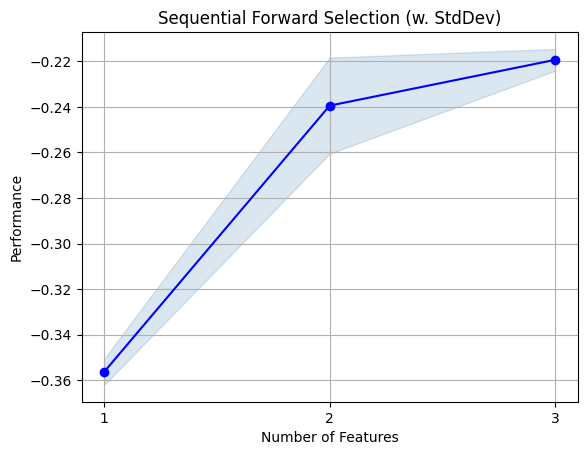

In [44]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [45]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x000001D1030D6790>),
                ('model', RandomForestClassifier())])

In [46]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_sfs, average='weighted')
metrics["recall"] = recall_score(y_test, predictions_sfs, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_sfs, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
  
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/22 10:14:30 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:30 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:30 INFO mlflow.tracking._tracking_service.client: üèÉ View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/56db1447a2eb43abab6181c90dda0624.
2025/10/22 10:14:30 INFO mlf

In [47]:
from sklearn.model_selection import  GridSearchCV

param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators':[i for i in range(1,5)],
    'model__max_features':[i/10 for i in range(1,10)]
}

gs = GridSearchCV(rfe_sfs_pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)



c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than 

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['battery_power',
                                                                          'clock_speed',
                                                                          'fc',
                                                                          'int_memory',
                                                                          'm_dep',
                                                                          'mobile_wt',
                                                                          'n_cores',
                                                                          'pc',
                                                                          'px_height',
                                                                          'px_width',
                                                                          'ram',
                                                                          'sc_h',
                                                                          'sc_w',
                                                                          'talk_time']),
                                                                        ('cat',
                                                                         TargetEncoder(),
                                                                         ['blue',
                                                                          'dual_sim',
                                                                          'four_g',
                                                                          'three_g',
                                                                          'touch_screen',
                                                                          'wifi']),
                                                                        ('quanti...
                                                                          'clock_speed']),
                                                                        ('spline',
                                                                         SplineTransformer(n_knots=3),
                                                                         ['battery_power'])])),
                                       ('rfe_extractor',
                                        <__main__.ColumnExtractor object at 0x000001D1030D6790>),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'model__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                 0.7, 0.8, 0.9],
                         'model__n_estimators': [1, 2, 3, 4]},
             scoring='neg_mean_absolute_error')

In [48]:
print("–õ—É—á—à–∏–µ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã:", gs.best_params_)

–õ—É—á—à–∏–µ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã: {'model__max_depth': 6, 'model__max_features': 0.5, 'model__n_estimators': 4}


In [49]:
classifier_optimized = RandomForestClassifier(max_depth=7, max_features=0.9, n_estimators=4)

In [50]:
rfe_skl_pipeline_optimised = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])
rfe_skl_pipeline_optimised.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x000001D105441010>),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=0.9,
                                        n_estimators=4))])

In [51]:
predictions_gridSV = rfe_skl_pipeline_optimised.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions_gridSV, average='weighted')
metrics["recall"] = recall_score(y_test, predictions_gridSV, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_gridSV, average='weighted')
metrics

{'precision': 0.8819493288374478,
 'recall': 0.8710601719197708,
 'f1': 0.8737136407050448}

In [52]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection_optimised_GridSearchSV'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
  
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_skl_pipeline_optimised, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/22 10:14:48 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:48 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:49 INFO mlflow.tracking._tracking_service.client: üèÉ View run rfe_feature_selection_optimised_GridSearchSV at: http://127.0.0.1:5000/#/experiments/1/runs/7e9a57e821ec4ff7b6b9e7bb7403776e.
2025/10/2

In [53]:

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optimized_random_forest_v2'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
   
    mlflow.sklearn.log_model(
        rfe_skl_pipeline_optimised, 
        artifact_path="models",
        signature=signature,
        input_example=input_example,
        pip_requirements=req_file
    )
    mlflow.log_metrics(metrics)
    mlflow.log_params(gs.best_params_)  
    
   
    model_version = mlflow.register_model(
        f"runs:/{run_id}/models",
        REGISTRY_MODEL_NAME,
        await_registration_for=300
    )
    
    
    client = mlflow.tracking.MlflowClient()
    client.update_model_version(
        name=REGISTRY_MODEL_NAME,
        version=model_version.version,
        description="Optimized Random Forest with GridSearchCV and RFE feature selection"
    )

print(f"Model registered as version {model_version.version} of {REGISTRY_MODEL_NAME}")

2025/10/22 10:14:49 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/22 10:14:49 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Registered model 'phone_model_rf' already exists. Creating a new version of this model...
2025/10/22 10:14:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish cre

Model registered as version 3 of phone_model_rf


In [54]:

X_full = df.drop('target', axis=1)
y_full = df['target']


production_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])

production_pipeline.fit(X_full, y_full)


from mlflow.models import infer_signature
signature = infer_signature(model_input=X_full.head(5))
input_example = X_full.head(5)


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'production_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    mlflow.sklearn.log_model(
        production_pipeline,
        artifact_path="models",
        signature=signature,
        input_example=input_example,
        pip_requirements=req_file
    )
    
  
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    
  
    model_version = mlflow.register_model(
        f"runs:/{run.info.run_id}/models",
        REGISTRY_MODEL_NAME
    )
    
  
    client = mlflow.tracking.MlflowClient()
    client.set_registered_model_tag(
        name=REGISTRY_MODEL_NAME,
        key="stage",
        value="Production"
    )
    
    
    client.update_model_version(
        name=REGISTRY_MODEL_NAME,
        version=model_version.version,
        description="Production model trained on full dataset with optimized parameters"
    )

print(f"Production model registered as version {model_version.version} of {REGISTRY_MODEL_NAME}")

c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/10/22 10:14:49 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, 

Production model registered as version 4 of phone_model_rf


In [ ]:

import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    classifier_trial = RandomForestClassifier(**params)
    pipeline_trial = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_idx)),
        ('model', classifier_trial)
    ])
    
    pipeline_trial.fit(X_train, y_train)
    predictions = pipeline_trial.predict(X_test)
    f1 = f1_score(y_test, predictions, average='weighted')
    
    return f1

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=20)  

best_params = study.best_params
print("–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:", best_params)

classifier_optimized = RandomForestClassifier(**best_params)
rfe_optuna_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])

rfe_optuna_pipeline.fit(X_train, y_train)

predictions_optuna = rfe_optuna_pipeline.predict(X_test)
metrics = {}
metrics["precision"] = precision_score(y_test, predictions_optuna, average='weighted')
metrics["recall"] = recall_score(y_test, predictions_optuna, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_optuna, average='weighted')

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection_optimised_Optuna'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(
        rfe_optuna_pipeline, 
        artifact_path="models",
        signature=signature,
        input_example=input_example,
        pip_requirements=req_file
    )
    mlflow.log_metrics(metrics)
    mlflow.log_params(best_params)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    
    
    model_version = mlflow.register_model(
        f"runs:/{run.info.run_id}/models",
        REGISTRY_MODEL_NAME,
        await_registration_for=300
    )
    
    client = mlflow.tracking.MlflowClient()
    client.update_model_version(
        name=REGISTRY_MODEL_NAME,
        version=model_version.version,
        description="Optimized Random Forest with Optuna and RFE feature selection"
    )

print(f"Model registered as version {model_version.version} of {REGISTRY_MODEL_NAME}")

[I 2025-10-22 10:14:50,148] A new study created in memory with name: no-name-6a02e642-a8cf-490d-a861-886f7183afbb
[I 2025-10-22 10:14:50,248] Trial 0 finished with value: 0.8613276228299065 and parameters: {'max_depth': 11, 'n_estimators': 57, 'max_features': 0.11373086182299659, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8613276228299065.
[I 2025-10-22 10:14:50,346] Trial 1 finished with value: 0.877918950954201 and parameters: {'max_depth': 19, 'n_estimators': 25, 'max_features': 0.5715891059504401, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.877918950954201.
[I 2025-10-22 10:14:50,509] Trial 2 finished with value: 0.8976544326262167 and parameters: {'max_depth': 10, 'n_estimators': 62, 'max_features': 0.49520286797169977, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8976544326262167.
[I 2025-10-22 10:14:50,710] Trial 3 finished with value: 0.8835769058011581 and parameters: {'max_

–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: {'max_depth': 15, 'n_estimators': 35, 'max_features': 0.3796210432310543, 'min_samples_split': 9, 'min_samples_leaf': 2}


2025/10/22 10:14:53 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Registered model 'phone_model_rf' already exists. Creating a new version of this model...
2025/10/22 10:14:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: phone_model_rf, version 5
Created version '5' of model 'phone_model_rf'.
2025/10/22 10:14:53 INFO mlflow.tracking._tracking_service.client: üèÉ View run rfe_feature_selection_optimised_Optuna at: http://127.0.0.1:5000/#/experiments/1/runs/1de74c0674984c12aeaa1ecd9799bad1.
2025/10/22 10:14:53 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://

Model registered as version 5 of phone_model_rf
